In [1]:
import torch
import torch.utils.data
from IPython import display
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
train_data.shape

(1460, 81)

In [4]:
test_data.shape

(1459, 80)

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2 ,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[: , 1:]))
all_features.shape

(2919, 79)

In [13]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean()) / (x.std()))
# 標準化後，每個特徵的均值變為0，所以可以直接⽤0來替換缺失值
all_features = all_features.fillna(0)

In [17]:
# dummy_na=True將缺失值也當作合法的特徵值並為其創建指示特徵
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

In [40]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice, dtype=torch.float).view(-1, 1)

In [49]:
# 使用一個基本的線性回歸模型和平方損失函數來訓練模型
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01) # 使用從正態分佈中得出的值填充輸入張量
    return net

In [50]:
# 對數均⽅根誤差
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 將小於1的值設成1，使得取對數時數值更穩定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2*loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

In [51]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels) # 轉換成torch能識別的Dataset
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True) # 將轉換的Dataset生成一個迭代器
    # 這裡使用了Adam優化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [52]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉驗證時所需要的訓練和驗證數據
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            # cat是concatnate的意思, 即拼接, 除拼接维数dim數值可不同外其餘维數數值需相同，方能對齊
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [53]:
def use_svg_diplay():
    # 用矢量圖表示
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_diplay()
    plt.rcParams['figure.figsize'] = figsize # 圖片像素

In [57]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

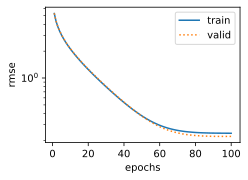

flod 0, train rmse 0.2405046969652176, valid rmse 0.2217017114162445
flod 1, train rmse 0.22887907922267914, valid rmse 0.26382213830947876
flod 2, train rmse 0.23147866129875183, valid rmse 0.23773878812789917
flod 3, train rmse 0.2383573204278946, valid rmse 0.21924297511577606
flod 4, train rmse 0.23054243624210358, valid rmse 0.25883135199546814
5-fold validation: avg train rmse 0.23395243883132935, avg valid rmse 0.24026739299297334


In [59]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data= get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                    range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print(f'flod {i}, train rmse {train_ls[-1]}, valid rmse {valid_ls[-1]}')
    return train_l_sum/k, valid_l_sum/k

k = 5
num_epochs = 100
lr = 5
weight_decay = 0
batch_size = 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train rmse {train_l}, avg valid rmse {valid_l}')

In [68]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse')
    print(f'train rmse {train_ls[-1]}')
    # depatch(), 返回一個新的Variable，從當前計算圖中分離下來的，但是仍指向原變量的存放位置,
    # 不同之處只是requires_grad為false，得到的這個Variable永遠不需要計算其梯度，不具有grad。
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv("./submission.csv", index=False)

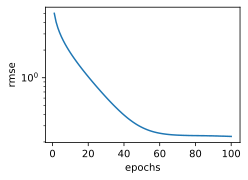

train rmse 0.22961805760860443


In [69]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

In [70]:
# 誤差均方根(RMSE)，結果越小越好